<a href="https://colab.research.google.com/github/Rama-Has/Poem_Generator_Rama_Hasiba_12010022/blob/main/English_Poem_Generator_NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Sections: 
  1. Fine tune a gpt-2 model.
  2. Build a bidirectional LSTM model to generate a poem.

## Importing Libraries

In [3]:
# !pip install tensorflow

In [6]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.models import load_model 
from google.colab import drive 
from tensorflow.keras.utils import to_categorical
from transformers import GPT2LMHeadModel, GPT2Tokenizer#take the input text then encode it from text to numbers
from sklearn.model_selection import train_test_split
from transformers import TextDataset, DataCollatorForLanguageModeling

# Reading Data
-------------------

In [7]:
#mount google drive to the colab runtime
drive.mount('/content/drive') 

Mounted at /content/drive


In [8]:
csv_data = pd.read_csv('/content/drive/MyDrive/Classroom/merged_data.csv') 

In [9]:
csv_data

,Unnamed: 0,Verse,Meter,char_count
0,0,ah why this boding start this sudden pain,iambic,6
1,1,that wings my pulse and shoots from vein to vein,iambic,6
2,2,what mean regardless of yon midnight bell,iambic,6
3,3,these earthborn visions saddening o'er my cell,iambic,6
4,4,what strange disorder prompts these thoughts t...,iambic,6
...,...,...,...,...
198997,202272,were mellow music matchd with him,iambic,6
198998,202274,o life as futile then as frail,iambic,6
198999,202275,o for thy voice to soothe and bless,iambic,6
199000,202276,what hope of answer or redress,iambic,6


The dataset consists of 4 columns, we are interested on the "Verse" one only. It contains 199002 sample(verse), I decided to train the model with 16000 sample due to the resource limitation I have.

In [10]:
csv_data = csv_data[['Verse']]

In [11]:
csv_data  

,Verse
0,ah why this boding start this sudden pain
1,that wings my pulse and shoots from vein to vein
2,what mean regardless of yon midnight bell
3,these earthborn visions saddening o'er my cell
4,what strange disorder prompts these thoughts t...
...,...
198997,were mellow music matchd with him
198998,o life as futile then as frail
198999,o for thy voice to soothe and bless
199000,what hope of answer or redress


## Preparing the Corpus

In [12]:
corpus = csv_data['Verse'].to_list()[0: 16000]

In [13]:
corpus[0: 4]

['ah why this boding start this sudden pain',
 'that wings my pulse and shoots from vein to vein',
 'what mean regardless of yon midnight bell',
 "these earthborn visions saddening o'er my cell"]

Get the length of each verse, where length represent number of words in that verse 


In [14]:
verse_length = [len(line.split(' ')) for line in corpus]
verse_length[0: 5]   

[8, 10, 7, 7, 8]

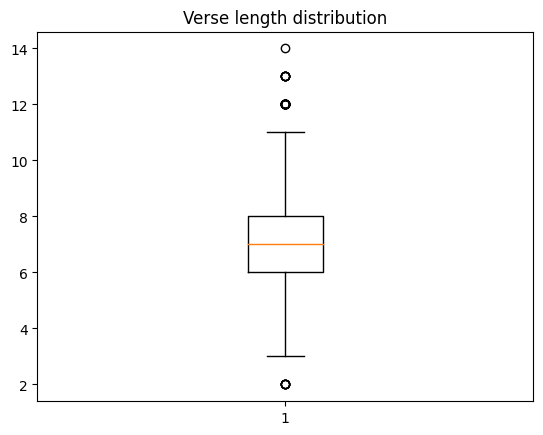

In [15]:
plt.boxplot(verse_length)
plt.title('Verse length distribution')
plt.show()

In [16]:
print(
    f'Longest verse has {max(verse_length)} word.'
    f'\nShorter one has {min(verse_length)}.' 
    f'\n{int(np.mean(verse_length))} is the mean number of words per verse.\n' 
)

Longest verse has 14 word.
Shorter one has 2.
7 is the mean number of words per verse.



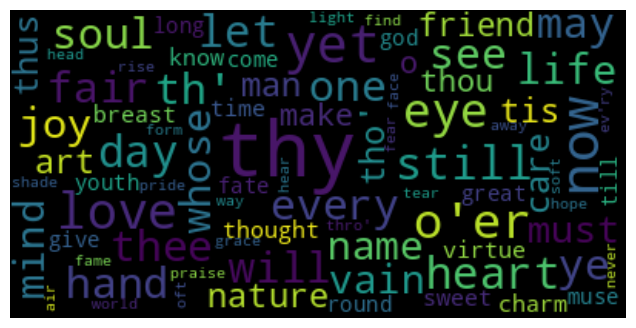

In [17]:
# Generating the wordCloud to visiualize the text
wordcloud = WordCloud(max_font_size=50,
                      max_words=80,
                      background_color="black").generate(" ".join(corpus))
 
# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

#### Text Preprocessing

Making samples, that I'll use in the training, consistant by converting letters to lower case.

> 1. Convert to lower case

In [18]:
corpus = [sentence.lower() for sentence in corpus]

### Tokenizing Data

Tokenize the text using tensorflow tokenizer.

In [19]:
#fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()

#fit the tokenizer on verses, where each word will be assigned to an integer.
tokenizer.fit_on_texts(corpus)

In [20]:
# help(tokenizer)

In [21]:
# Tokenized words
tokenizer.word_index

{'the': 1,
 'and': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'a': 6,
 'with': 7,
 'his': 8,
 'her': 9,
 'that': 10,
 'my': 11,
 'i': 12,
 'thy': 13,
 'from': 14,
 'all': 15,
 'for': 16,
 'but': 17,
 'he': 18,
 'their': 19,
 'on': 20,
 'as': 21,
 'or': 22,
 'by': 23,
 'when': 24,
 'no': 25,
 'not': 26,
 'is': 27,
 'be': 28,
 'you': 29,
 'at': 30,
 'your': 31,
 'they': 32,
 'who': 33,
 'what': 34,
 'this': 35,
 'shall': 36,
 'she': 37,
 'was': 38,
 'nor': 39,
 'so': 40,
 'now': 41,
 'where': 42,
 'me': 43,
 'it': 44,
 'yet': 45,
 'more': 46,
 'can': 47,
 'then': 48,
 'each': 49,
 'which': 50,
 'are': 51,
 "o'er": 52,
 'our': 53,
 'if': 54,
 'while': 55,
 'love': 56,
 'still': 57,
 'we': 58,
 'like': 59,
 'let': 60,
 'how': 61,
 'him': 62,
 'there': 63,
 'its': 64,
 'thou': 65,
 'every': 66,
 "th'": 67,
 'thee': 68,
 'some': 69,
 'fair': 70,
 'heart': 71,
 'will': 72,
 'see': 73,
 'too': 74,
 'these': 75,
 'an': 76,
 'here': 77,
 'soul': 78,
 'may': 79,
 'such': 80,
 'one': 81,
 'day': 82,
 'ye':

In [22]:
# vocabulary count of the corpus
number_of_words = len(tokenizer.word_index)
 
print(f"number of words:\n {number_of_words}")

number of words:
 13453


# Preparing Data

> encode the tokenized words, convert text data to numerical tokens.

In [23]:
#encode the tokenized words, convert text data to numerical tokens
encoded_text = tokenizer.texts_to_sequences(corpus)

#add 1 to the size for the out of vocabulary token.
vocab_size = len(tokenizer.word_counts) + 1

In [24]:
encoded_text[0: 4]       

[[164, 128, 35, 3727, 977, 35, 774, 227],
 [10, 600, 11, 1769, 2, 3728, 14, 1042, 3, 1042],
 [34, 544, 2255, 4, 346, 915, 1770],
 [75, 6861, 1574, 6862, 52, 11, 1771]]

> g:enerate embedding for every sentence in the corpus.


In [25]:
data_list = []

for encoded_verse in encoded_text:
    if len(encoded_verse) > 1:       
        for i in range(1, len(encoded_verse)):
            data_list.append(encoded_verse[: i + 1]) 

In [26]:
data_list[0: 5]

[[164, 128],
 [164, 128, 35],
 [164, 128, 35, 3727],
 [164, 128, 35, 3727, 977],
 [164, 128, 35, 3727, 977, 35]]

# Padding

In [27]:
# !pip install tensorflow

> pad all embeddings to the maximum embedded length, by filling zeros. So all embeddings have the same length.

In [28]:
#Padding will make sure all data points have the same length because verses don't have the same length.
sequences = pad_sequences(
    data_list, 
    maxlen = max(verse_length), 
    padding='pre'
    )

X = sequences[:, :-1]

#Labels
y = sequences[:, -1] 

In [30]:
X[0: 4]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  164],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         164,  128],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  164,
         128,   35],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  164,  128,
          35, 3727]], dtype=int32)

In [31]:
y[0: 4]

array([ 128,   35, 3727,  977], dtype=int32)

In [32]:
#convert label values to one hot encoded list
y = to_categorical(
    y,
    num_classes = vocab_size
    )

y[0: 4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
seq_length = X.shape[1]

## Bi-directional LSTM Model Training

In [34]:
# create a Sequential model
model = Sequential()

# Add an Embedding layer
model.add(Embedding(
    vocab_size, #input dim
    100, #output dim   
    input_length = seq_length
    )
)

model.add(Bidirectional(
    LSTM(150, #number of hidden units
         return_sequences=True #return the full sequence to the output
         )
    )
)

model.add(Bidirectional(LSTM(150, return_sequences=True)))

# add a Dropout layer for regularization to prevent overfitting
model.add(Dropout(0.2))
 
model.add(LSTM(100, return_sequences=True))
 
model.add(LSTM(100))
 
model.add(Dense(vocab_size, activation='relu'))

# add the output layer with vocab_size units and softmax activation, to get probability for each word.
model.add(Dense(vocab_size, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
    )


In [35]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 100)           1345400   
                                                                 
 bidirectional (Bidirectiona  (None, 13, 300)          301200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 13, 300)          541200    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 13, 300)           0         
                                                                 
 lstm_2 (LSTM)               (None, 13, 100)           160400    
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [ ]:
# model.fit(
#     X, 
#     y, 
#     batch_size=256, 
#     epochs=100
#     )

Epoch 1/100
297/297 [==============================] - 56s 149ms/step - loss: 7.3220 - accuracy: 0.0631
Epoch 2/100
297/297 [==============================] - 34s 116ms/step - loss: 6.8811 - accuracy: 0.0735
Epoch 3/100
297/297 [==============================] - 34s 116ms/step - loss: 6.6353 - accuracy: 0.0815
Epoch 4/100
297/297 [==============================] - 35s 118ms/step - loss: 6.3867 - accuracy: 0.0902
Epoch 5/100
297/297 [==============================] - 34s 113ms/step - loss: 6.1666 - accuracy: 0.0956
Epoch 6/100
297/297 [==============================] - 34s 114ms/step - loss: 5.9818 - accuracy: 0.1009
Epoch 7/100
297/297 [==============================] - 33s 112ms/step - loss: 5.8122 - accuracy: 0.1052
Epoch 8/100
297/297 [==============================] - 34s 114ms/step - loss: 5.6393 - accuracy: 0.1108
Epoch 9/100
297/297 [==============================] - 33s 112ms/step - loss: 5.4647 - accuracy: 0.1164
Epoch 10/100
297/297 [==============================] - 34s 116m

### Save the Model

In [ ]:
model.save('./double_di')

In [ ]:
# Compress model folder into a zip file
shutil.make_archive("/content/double_di", "zip", "/content/double_di")

# Download model compressed file
files.download("/content/double_di.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-----------------------------
# Fine Tune gpt-2

In [36]:
df = pd.DataFrame(corpus, columns = ['verse'])
df

,verse
0,ah why this boding start this sudden pain
1,that wings my pulse and shoots from vein to vein
2,what mean regardless of yon midnight bell
3,these earthborn visions saddening o'er my cell
4,what strange disorder prompts these thoughts t...
...,...
15995,for ever lives the particle divine
15996,yet make myy tomb to future ages known
15997,and with a modest verse inscribe the stone
15998,the verse shall preach some moral truth to man


In [37]:
df.to_csv(
    r'full_text.txt', 
    header=None, 
    index=None, 
    sep=' ',
    mode='a'
    )

### Load the GPT Model
GPT-2

In [38]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.1 MB/s eta 0:00:00


In [15]:
# !pip install git+https://github.com/huggingface/transformers

In [16]:
# !pip install --upgrade transformers

In [40]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id = gpt_tokenizer.eos_token_id)

In [41]:
gpt_tokenizer.decode(gpt_tokenizer.eos_token_id)

'<|endoftext|>'

# Tokenizing

In [42]:
corpus[:5]

['ah why this boding start this sudden pain',
 'that wings my pulse and shoots from vein to vein',
 'what mean regardless of yon midnight bell',
 "these earthborn visions saddening o'er my cell",
 'what strange disorder prompts these thoughts to glow']

In [43]:
train_path = '/content/train_dataset.txt'
test_path = '/content/test_dataset.txt'

In [45]:
train, test = train_test_split(
    df, 
    test_size=0.15, 
    shuffle=False
    )

In [46]:
train.to_csv(
    r'train_dataset.txt', 
    header=None, 
    index=None, 
    sep=' ', 
    mode='a'
    )

test.to_csv(
    r'test_dataset.txt', 
    header=None, 
    index=None, 
    sep=' ', 
    mode='a'
    )

In [56]:
def remove_double_qoutes(file_path: str) -> None: 
  
    # Read the file
    with open(file_path, 'r') as file:
        text = file.read()

    # Remove double quotes
    text_without_quotes = text.replace('"', '')

    # Write the modified text back to the file
    with open(file_path, 'w') as file:
        file.write(text_without_quotes)

In [57]:
remove_double_qoutes(train_path)
remove_double_qoutes(test_path)

In [58]:
# !pip install transformers==4.28.0

In [59]:
def load_dataset(train_path, test_path, tokenizer):
  
    train_dataset = TextDataset(
          tokenizer = gpt_tokenizer,
          file_path = train_path,
          block_size=128
          )

    test_dataset = TextDataset(
          tokenizer = gpt_tokenizer,
          file_path = test_path,
          block_size=128
          )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer = gpt_tokenizer, 
        mlm = False,
    )

    return train_dataset,test_dataset,data_collator

In [69]:
from transformers import Trainer, TrainingArguments, AutoModelWithLMHead
from transformers import pipeline
import shutil

In [61]:
train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, gpt_tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [63]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 3.5 MB/s eta 0:00:00


In [67]:
training_args = TrainingArguments(
    #The output directory
    output_dir = "./gpt2-Poems", 
    #overwrite the content of the output directory
    overwrite_output_dir = True, 
    # number of training epochs
    num_train_epochs = 15, 
    # batch size for training
    per_device_train_batch_size=32,
    # batch size for evaluation 
    per_device_eval_batch_size=64, 
    # Number of update steps between two evaluations. 
    eval_steps = 400, 
    # after # steps model is saved
    save_steps=800, 
    # number of warmup steps for learning rate scheduler
    warmup_steps=500,
    )

trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [39]:
# trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.968900


TrainOutput(global_step=540, training_loss=3.9293535868326823, metrics={'train_runtime': 599.9279, 'train_samples_per_second': 28.753, 'train_steps_per_second': 0.9, 'total_flos': 1126821888000000.0, 'train_loss': 3.9293535868326823, 'epoch': 15.0})

In [40]:
trainer.save_model('./gpt_for_poems')

# Compress the folder into a zip file
shutil.make_archive("/content/gpt_for_poems", "zip", "/content/gpt_for_poems")


'/content/gpt_for_poems.zip'

In [42]:
generator_ = pipeline(
    'text-generation', 
    model='./gpt_for_poems', 
    tokenizer = gpt_tokenizer
    )

In [45]:
max_words = 50  # Set the desired maximum number of words
generator_ = pipeline(
    'text-generation', 
    model='./gpt_for_poems', 
    tokenizer = gpt_tokenizer
    )
result = generator_('Love ', max_length = 60)[0]['generated_text']